https://deepnote.com/blog/semantic-search-using-faiss-and-mpnet

In [1]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F


# https://huggingface.co/sentence-transformers/all-mpnet-base-v2
class SemanticEmbedding:
    def __init__(self, model_name="sentence-transformers/all-mpnet-base-v2"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)

    # Mean Pooling - Take attention mask into account for correct averaging
    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0]  # First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def get_embedding(self, sentences):
        # Tokenize sentences
        encoded_input = self.tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad():
            model_output = self.model(**encoded_input)
        # Perform pooling
        sentence_embeddings = self.mean_pooling(model_output, encoded_input["attention_mask"])

        # Normalize embeddings
        sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
        return sentence_embeddings.detach().numpy()

In [2]:
model = SemanticEmbedding()
model.model

MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0): MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): Linear(in_features=768, out_features=768, bias=True)
            (k): Linear(in_features=768, out_features=768, bias=True)
            (v): Linear(in_features=768, out_features=768, bias=True)
            (o): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (intermediate): MPNetIntermediate(
          (dense): Linear(in_features

In [18]:
# This model can process a maximum of 514 tokens?

In [3]:
a = model.get_embedding("I love playing football")
a.shape

(1, 768)

# Faiss

In [4]:
import faiss
import numpy as np

In [5]:
class FaissIdx:
    def __init__(self, model, dim=768):
        self.index = faiss.IndexFlatIP(dim)
        # Maintaining the document data
        self.doc_map = dict()
        self.model = model
        self.ctr = 0  # counter for the number of documents added

    def add_doc(self, document_text):
        self.index.add(self.model.get_embedding(document_text))
        self.doc_map[self.ctr] = document_text  # store the original document text
        self.ctr += 1

    def search_doc(self, query, k=3):
        D, I = self.index.search(self.model.get_embedding(query), k)
        return [{self.doc_map[idx]: score} for idx, score in zip(I[0], D[0]) if idx in self.doc_map]

In [6]:
index = FaissIdx(model)
index.add_doc("laptop computers")
index.add_doc("doctor's office")
index.search_doc("PC computer")

[{'laptop computers': 0.7276022}, {"doctor's office": 0.2555444}]

## Final Setup

In [7]:
import requests
from io import StringIO
import pandas as pd

In [8]:
arxiv_df = pd.read_csv("data/arxiv_processed.csv")

In [12]:
arxiv_df["text"] = arxiv_df["title"] + " " + arxiv_df["abstract"]

In [13]:
arxiv_df

,abstract,title,url,text
0,A fully differential calculation in perturba...,Calculation of prompt diphoton production cros...,https://arxiv.org/abs/0704.0001,Calculation of prompt diphoton production cros...
1,"We describe a new algorithm, the $(k,\ell)$-...",Sparsity-certifying Graph Decompositions,https://arxiv.org/abs/0704.0002,Sparsity-certifying Graph Decompositions We ...
2,The evolution of Earth-Moon system is descri...,The evolution of the Earth-Moon system based o...,https://arxiv.org/abs/0704.0003,The evolution of the Earth-Moon system based o...
3,We show that a determinant of Stirling cycle...,A determinant of Stirling cycle numbers counts...,https://arxiv.org/abs/0704.0004,A determinant of Stirling cycle numbers counts...
4,In this paper we show how to compute the $\L...,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,https://arxiv.org/abs/0704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...
...,...,...,...,...
2190406,We report on measurements of the angular dep...,On the origin of the irreversibility line in t...,https://arxiv.org/abs/0supr-con/9608008,On the origin of the irreversibility line in t...
2190407,The non-linear microwave surface impedance o...,Nonlinear Response of HTSC Thin Film Microwave...,https://arxiv.org/abs/0supr-con/9609001,Nonlinear Response of HTSC Thin Film Microwave...
2190408,The vortex contribution to the dc field (H) ...,Critical State Flux Penetration and Linear Mic...,https://arxiv.org/abs/0supr-con/9609002,Critical State Flux Penetration and Linear Mic...
2190409,We show that the density of states in an ani...,Density of States and NMR Relaxation Rate in A...,https://arxiv.org/abs/0supr-con/9609003,Density of States and NMR Relaxation Rate in A...


In [21]:
import matplotlib.pyplot as plt

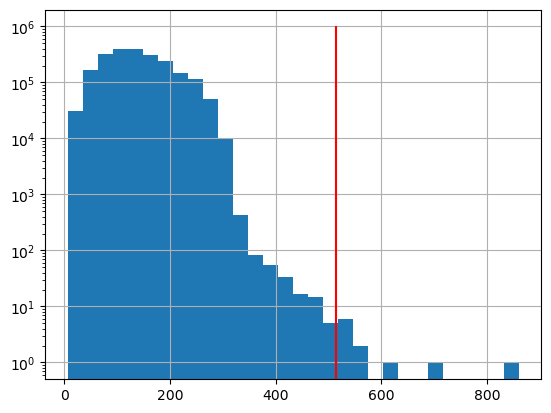

In [24]:
# Count number of words in text column
arxiv_df["text"].apply(lambda x: len(x.split(" "))).hist(bins=30)
plt.yscale("log")
plt.vlines(514, 0, 10 ** 6, colors="red")

In [26]:
# Testing performance
arxiv_df[arxiv_df["text"] == "The discrete dipole approximation for simulation of light scattering by\n  particles much larger than the wavelength   In this manuscript we investigate the capabilities of the Discrete Dipole\nApproximation (DDA) to simulate scattering from particles that are much larger\nthan the wavelength of the incident light, and describe an optimized publicly\navailable DDA computer program that processes the large number of dipoles\nrequired for such simulations. Numerical simulations of light scattering by\nspheres with size parameters x up to 160 and 40 for refractive index m=1.05 and\n2 respectively are presented and compared with exact results of the Mie theory.\nErrors of both integral and angle-resolved scattering quantities generally\nincrease with m and show no systematic dependence on x. Computational times\nincrease steeply with both x and m, reaching values of more than 2 weeks on a\ncluster of 64 processors. The main distinctive feature of the computer program\nis the ability to parallelize a single DDA simulation over a cluster of\ncomputers, which allows it to simulate light scattering by very large\nparticles, like the ones that are considered in this manuscript. Current\nlimitations and possible ways for improvement are discussed.\n"]["url"]

36    https://arxiv.org/abs/0704.0037
Name: url, dtype: object

In [14]:
res = requests.get("https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/sick2014/SICK_train.txt")
# create dataframe
data = pd.read_csv(StringIO(res.text), sep="\t")
data.head()

,pair_ID,sentence_A,sentence_B,relatedness_score,entailment_judgment
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,4.5,NEUTRAL
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,3.2,NEUTRAL
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,4.7,ENTAILMENT
3,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,3.4,NEUTRAL
4,9,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,3.7,NEUTRAL


In [15]:
# Remove Duplicates
data.drop_duplicates(subset="sentence_A", inplace=True)
data.shape

(3146, 5)

In [16]:
# Usually takes less than 10 minutes
# %%time
for idx, row in data.iterrows():
    index.add_doc(row["sentence_A"])

In [17]:
# Save index
faiss.write_index(index.index, "index.faiss")

### Test it

In [11]:
index.search_doc("yellow train is going by")

[{'A yellow dog is stopping on white snow on a sunny day': 0.44798172},
 {'A yellow dog is running on white snow on a sunny day': 0.38209292},
 {'A schoolgirl with a black bag is on a crowded train': 0.38048455}]

In [13]:
index.search_doc("sprinting with football")

[{'A player is running with the ball': 0.59186924},
 {'A group of people playing football is running in the field': 0.5844322},
 {'A group of football players is running in the field': 0.55432737}]